# Importing and exploring fashion mnist

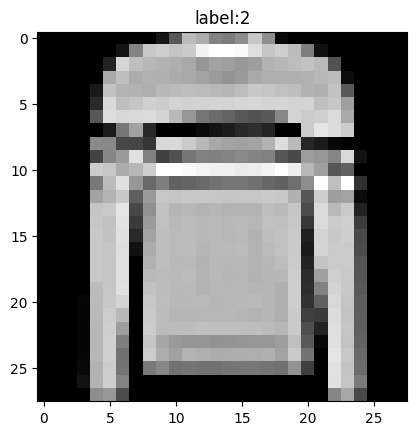

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


transform= transform = transforms.Compose([
    transforms.ToTensor(),                
    transforms.Normalize((0.5,), (0.5,))   # mean, std for grayscale
])


train_dataset= datasets.FashionMNIST(root='./data', train=True , transform=transform, download=True)
test_dataset= datasets.FashionMNIST(root="./data", train=False, transform=transform , download=True)

image,label= train_dataset[5]

classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"label:{label}")
plt.show()

# Creating dataloaders

In [2]:
train_set, val_set= random_split(train_dataset, [50000, 10000])

train_loader= DataLoader(train_set, batch_size=128, shuffle=True)
val_loader= DataLoader(val_set, batch_size= 128, shuffle=False)
test_loader= DataLoader(test_dataset, batch_size=128, shuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))



391
79
79


# Building a network

In [3]:
class FashionClassifer(nn.Module):

    def __init__(self):
        super().__init__()

        self.flatten= nn.Flatten() # 28*28 pixels to 784 raw features

        self.layer1= nn.Linear(784, 256)
        self.bn1= nn.BatchNorm1d(256)
        self.relu1= nn.ReLU()
        self.drp1= nn.Dropout(p=0.05)

        self.layer2= nn.Linear(256, 128)
        self.bn2= nn.BatchNorm1d(128)
        self.relu2= nn.ReLU()
        self.drp2= nn.Dropout(p=0.05)

        self.layer3= nn.Linear(128, 64)
        self.bn3= nn.BatchNorm1d(64)
        self.relu3= nn.ReLU()
        self.drp3= nn.Dropout(p=0.05)

        self.layer4= nn.Linear(64, 10)

    def forward(self, x):
        x= self.flatten(x)

        x= self.bn1(self.layer1(x))
        x= self.drp1(self.relu1(x))

        x= self.bn2(self.layer2(x))
        x= self.drp2(self.relu2(x))

        x= self.bn3(self.layer3(x))
        x= self.drp3(self.relu3(x))

        x= self.layer4(x)

        return x 
    


model= FashionClassifer()

# training loop

In [6]:
optimizer= torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode= 'min',
    factor= 0.1,
    patience=3,
    verbose=True

)
criterion= nn.CrossEntropyLoss()

best_loss= float("inf")

num_epochs=10

for epoch in range(num_epochs):
    model.train()
    running_loss=0

    for batch_idx, (images,labels) in enumerate(train_loader):

        output= model(images)
        loss= criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f'batch: [{batch_idx+1}/{len(train_loader)}] | epoch: [{epoch+1}/{num_epochs}] | loss: {loss.item()}')
    
    avg_train_loss= running_loss/ len(train_loader)
    print(f'epoch: [{epoch+1}/{num_epochs}] | average train loss: {avg_train_loss}')

    model.eval()
    val_running_loss=0
    with torch.no_grad():
        for val_images, val_labels in val_loader:

            output= model(val_images)
            val_loss= criterion(output, val_labels)

            val_running_loss += val_loss.item()

    avg_val_loss= val_running_loss/len(val_loader)
    print(f'epoch: [{epoch+1}/{num_epochs}] | average val loss: {avg_val_loss}')

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_loss:
        best_loss= avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")


batch: [100/391] | epoch: [1/10] | loss: 0.6142764091491699
batch: [200/391] | epoch: [1/10] | loss: 0.5602337718009949
batch: [300/391] | epoch: [1/10] | loss: 0.44427725672721863
epoch: [1/10] | average train loss: 0.5327364107227082
epoch: [1/10] | average val loss: 0.4385758159281332
batch: [100/391] | epoch: [2/10] | loss: 0.4523370862007141
batch: [200/391] | epoch: [2/10] | loss: 0.5154675841331482
batch: [300/391] | epoch: [2/10] | loss: 0.35723838210105896
epoch: [2/10] | average train loss: 0.4107887552827216
epoch: [2/10] | average val loss: 0.36513866653925253
batch: [100/391] | epoch: [3/10] | loss: 0.38250336050987244
batch: [200/391] | epoch: [3/10] | loss: 0.23910640180110931
batch: [300/391] | epoch: [3/10] | loss: 0.3444630801677704
epoch: [3/10] | average train loss: 0.3564666827087817
epoch: [3/10] | average val loss: 0.3388867291468608
batch: [100/391] | epoch: [4/10] | loss: 0.33115410804748535
batch: [200/391] | epoch: [4/10] | loss: 0.4285910725593567
batch: [30

# Evaluating model

In [7]:
total = 0
correct = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)              
        predicted = outputs.argmax(dim=1)    

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100.0 * correct / total
print(accuracy)


88.56


# Testing on individual images

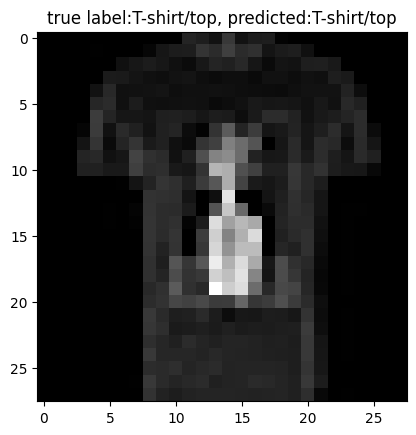

In [12]:
import random

model.eval()

idx= random.randint(0, len(test_dataset)-1)
images, labels= test_dataset[idx]

with torch.no_grad():
    output= model(images.unsqueeze(0))
    _, predicted= torch.max(output, 1)

plt.imshow(images.squeeze(), cmap='gray')
plt.title(f'true label:{classes[labels]}, predicted:{classes[predicted.item()]}')
plt.show()

# Finding mistakes in model

109 found in 1000 images


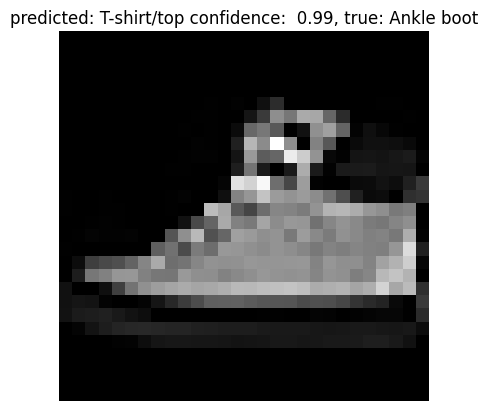

In [21]:
mistakes=[]

model.eval()

with torch.no_grad():

    for idx in range(1000):
            image, true_label= test_dataset[idx]
            output= model(image.unsqueeze(0))

            probs= torch.softmax(output, dim=1)
            pred= probs.argmax(dim=1).item()
            conf= probs[0, pred].item()

            if pred != true_label:
                mistakes.append((idx, true_label, predicted, conf))

    print(f'{len(mistakes)} found in 1000 images')

mistakes.sort(key=lambda x: x[3], reverse=True)

idx, label, predicted, conf= mistakes[2]
images, _= test_dataset[idx]

plt.imshow(images.squeeze(), cmap='gray')
plt.title(f"predicted: {classes[predicted.item()]} confidence: {conf: .2f}, true: {classes[label]}")
plt.axis("off")
plt.show()
